In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [2]:
import pandas as pd
from itertools import product
import math

# Data

In [16]:
data = pd.read_csv('2023_DS2_HW1_data_train.csv', sep = ',', decimal = '.', index_col = 'Booking_ID')

In [17]:
data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN16851,2.0,NaN,NaN,NaN,Meal Plan 1,NaN,NaN,43.0,2017.0,12.0,26.0,Offline,NaN,0.0,0.0,NaN,2.0,0.0
INN06266,1.0,NaN,NaN,2.0,Meal Plan 2,0.0,Room_Type 1,102.0,2017.0,10.0,NaN,Online,NaN,0.0,NaN,80.0,NaN,1.0
INN11285,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2018.0,5.0,NaN,Corporate,0.0,0.0,0.0,NaN,1.0,0.0


In [18]:
# define list of predictors
cols_pred = list(data.columns[0:-1])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']


Booking_ID: unique identifier of each booking
no_of_adults: Number of adults
no_of_children: Number of Children
no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
type_of_meal_plan: Type of meal plan booked by the customer:
required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
lead_time: Number of days between the date of booking and the arrival date
arrival_year: Year of arrival date
arrival_month: Month of arrival date
arrival_date: Date of the month
market_segment_type: Market segment designation.
repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
booking_status: Flag indicating if the booking was canceled or not.

In [19]:
cols_pred_num

#arrival date je blbost kterou vyhodim, ale arrival month bych asi mohla udelat kategorickej
#ostatni promenny jsou bud skutecne numericky nebo 0-1

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

In [20]:
cols_pred_num.remove('arrival_month')
cols_pred_cat.append('arrival_month')

In [21]:
data = data.dropna(subset=['booking_status'])
data.booking_status.value_counts(dropna=False)

0.0    21774
1.0    10521
Name: booking_status, dtype: int64

In [22]:

#kdybychom chteli stratifikovat podle neceho dalsiho, museli bychom zlikvidovat unavailable data, coz je skoda. zaroven stratifikace podle booking status asi trochu pomaha - soude z grafu nize
data_train, data_rest = train_test_split(data, test_size=0.4, random_state = 12,stratify = (data[["booking_status"]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[["booking_status"]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

/var/folders/qt/9ghf87fd40589wf9l6s3w6680000gn/T/ipykernel_76253/3272553581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data_train.index, 'sample'] = 'train'


In [23]:
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid')
test_mask = (data['sample'] == 'test')

In [24]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, np.mean)
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 1])
    plt.ylabel('default rate')
    plt.xlabel('month')
    plt.show()

InvalidIndexError: (slice(None, None, None), None)

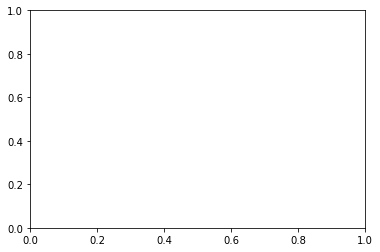

In [25]:
col_target = "booking_status"

default_rate_in_time_per_sample(data,col_target, 'arrival_month','sample')

# Data processing

In [26]:
# find columns with infinity values
cols_with_inf = []
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')
print("No other columns with infinity values")

No other columns with infinity values


# categorical variables ecoding

In [27]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, np.mean),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [28]:
total_dr = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 5:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data['MTE_' + pred] = data[pred].replace(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/4 [00:00<?, ?it/s]

/var/folders/qt/9ghf87fd40589wf9l6s3w6680000gn/T/ipykernel_76253/2915958815.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MTE_' + pred] = data[pred].replace(new_vals)
/var/folders/qt/9ghf87fd40589wf9l6s3w6680000gn/T/ipykernel_76253/2915958815.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MTE_' + pred] = data[pred].replace(new_vals)
/var/folders/qt/9ghf87fd40589wf9l6s3w6680000gn/T/ipykernel_76253/2915958815.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

# Model

In [29]:
# set best parameters to be used in XGBoost
params = {    
    'max_depth': 4,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

NameError: name 'xgb' is not defined

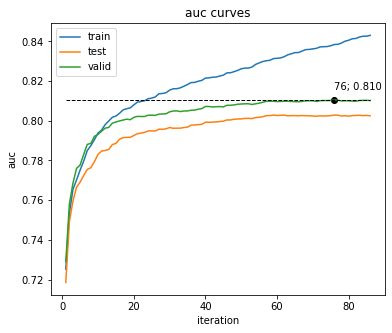

In [35]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')
plt.show()

In [36]:
percent_nan_in_each_col = (data.isna().sum()/(len(data))*100)
print(percent_nan_in_each_col)
print(np.sort(percent_nan_in_each_col))

no_of_adults                            13.574857
no_of_children                          84.554885
no_of_weekend_nights                    76.312123
no_of_week_nights                       25.626258
type_of_meal_plan                       49.326521
required_car_parking_space              45.273262
room_type_reserved                      65.183465
lead_time                               78.783093
arrival_year                             9.180988
arrival_month                            2.774423
arrival_date                            83.303917
market_segment_type                     43.229602
repeated_guest                          76.528874
no_of_previous_cancellations             0.213655
no_of_previous_bookings_not_canceled    44.790215
avg_price_per_room                      72.237188
no_of_special_requests                  22.799195
booking_status                           0.000000
sample                                   0.000000
MTE_type_of_meal_plan                   49.326521


                               predictor   strength
0                           arrival_year  38.512685
1                 no_of_special_requests  25.756696
2                MTE_market_segment_type  21.732730
3                      MTE_arrival_month  17.887769
4                              lead_time  15.675953
5                           no_of_adults   9.960220
6   no_of_previous_bookings_not_canceled   9.710450
7                  MTE_type_of_meal_plan   8.503809
8             required_car_parking_space   7.879530
9                      no_of_week_nights   7.831687
10                    avg_price_per_room   6.477318
11                  no_of_weekend_nights   5.486251
12                MTE_room_type_reserved   4.402821
13                        repeated_guest   4.001033
14                        no_of_children   3.842909
15                          arrival_date   3.390364
16          no_of_previous_cancellations   2.638611


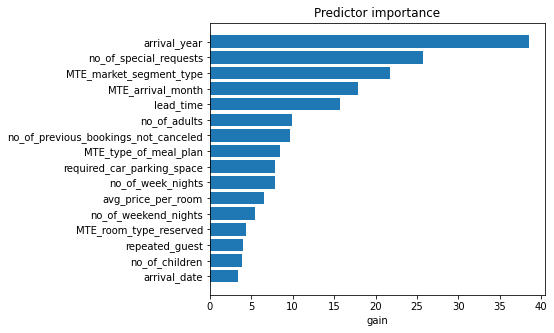

In [37]:
importance_type = 'gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])
fig = plt.figure(figsize=(6,5))
print(predictor_strength)
n_strongest = 16
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:16])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:16])
plt.xlabel(importance_type)
plt.title('Predictor importance')
plt.show()

In [34]:
cols_pred
to_remove = ["arrival_date","no_of_children","repeated_guest","MTE_room_type_reserved"]
questionable = ["avg_price_per_room","MTE_type_of_meal_plan","required_car_parking_space","no_of_previous_bookings_not_canceled"]

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type',
 'MTE_arrival_month']

Arrival date je blbost a ma maly vliv ,tak ho muzu vyhodt.

Number of children,repeated guest,no_of_weekend_nights, a room type reserved ma hodne unavailable a ma maly vliv, tak ho vyhodim

S otaznikem zustava
avg_price_per_room                      72.237188
MTE_type_of_meal_plan                   49.326521
required_car_parking_space              45.273262
no_of_previous_bookings_not_canceled    44.790215

nizky vliv ma take no_of_previous_cancellations   1.826715, asi proto, ze tam jsou vsechny pozorovani skoro stejny, tka to klidne muzu vyhodit, ale tim spis nechat no of previous not canceled.



no_of_previous cancelations ma fakt malo NAN a je docela uzitecne. mohlo by se pouzit pro stratifikaci. jenze ma taky skoro vzdy odpoved 0, takze zas tak zajimavy neni. Dal by se zvazit pocet mesicu.
lead_time ma hodne NaN, ale i tak je vcelku logicky uzitecny

no_of_adults: Number of adults
no_of_children: Number of Children
no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
type_of_meal_plan: Type of meal plan booked by the customer:
required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
lead_time: Number of days between the date of booking and the arrival date
arrival_year: Year of arrival date
arrival_month: Month of arrival date
arrival_date: Date of the month
market_segment_type: Market segment designation.
repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)


In [3]:
params_gs = {
    'eta': [0.05] #, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 4, 5],
    'lambda': [0, 0.1]#, 1, 10]
}

# create all combinations of parameters
param_combinations = list(product(*params_gs.values()))

# create a DataFrame with the parameter combinations
param_df = pd.DataFrame(param_combinations, columns=params_gs.keys())

# print the DataFrame
#print(param_df)


In [36]:
cols_pred
to_remove = ["arrival_date","no_of_children","repeated_guest","MTE_room_type_reserved"]
questionable = ["avg_price_per_room","MTE_type_of_meal_plan","required_car_parking_space","no_of_previous_bookings_not_canceled"]

In [40]:
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]})

aaa = cols_pred
bbb = [x for x in cols_pred if x not in to_remove]
ccc = [x for x in bbb if x not in questionable]

predictor_set_list = [aaa,bbb,ccc]

ccc

['no_of_adults',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'arrival_year',
 'no_of_previous_cancellations',
 'no_of_special_requests',
 'MTE_market_segment_type',
 'MTE_arrival_month']

In [6]:
# Initialize the first row and first column values
first_row = list(range(0, 60))
first_col = list(range(0, 3))

# Create an empty data frame with the given row and column labels
df = pd.DataFrame(index=first_col, columns=first_row)

# Fill the data frame with the product of the row and column values
for row in first_col:
    for col in first_row:
#        list_of_results=[]
#        for i in range(5):
        ETA = param_df.iloc[col, 0]
        max_depth = param_df.iloc[col, 1]
        MY_lambda = param_df.iloc[col, 2]
            
        predictor_set = predictor_set_list[row]
            
  #-------------------------------------------------------------------------------------------------------------------      
        
        # set best parameters to be used in XGBoost
        params = {    
            'max_depth': max_depth,
            'eta': ETA,
            'lambda': MY_lambda,
            "subsample":0.7,
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
        }


        evals_result = {}
        booster = xgb.train(
            params = params,
            dtrain = xgb.DMatrix(data[train_mask][predictor_set], data[train_mask][col_target]),
            num_boost_round = 1000,
            evals = (
                (xgb.DMatrix(data[train_mask][predictor_set], data[train_mask][col_target]), 'train'),
                (xgb.DMatrix(data[test_mask][predictor_set], data[test_mask][col_target]), 'test'),
                (xgb.DMatrix(data[valid_mask][predictor_set], data[valid_mask][col_target]), 'valid')
            ),
            evals_result = evals_result,
            early_stopping_rounds = 10
        )


        y_pred = model.predict(data[valid_mask])
        y_valid = data[valid_mask][col_target]
        auc_score = roc_auc_score(y_valid, y_pred)



      
 #-------------------------------------------------------------------------------------------------------------------       
        AUC = row * ETA
            
            
#            list_of_results.append(AUC)
            
#        average = sum(list_of_results) / len(list_of_results)
#        var_res = math.sqrt(sum((xi - average) ** 2 for xi in list_of_results) / len(list_of_results))

#        result = str(average) + "(" + str(var_res) + ")"
        result =  AUC
        df.at[row, col] = result

print(df)

          0          1          2          3          4          5   \
0   0.0(0.0)   0.0(0.0)   0.0(0.0)   0.0(0.0)   0.0(0.0)   0.0(0.0)   
1  0.05(0.0)  0.05(0.0)  0.05(0.0)  0.05(0.0)  0.05(0.0)  0.05(0.0)   
2   0.1(0.0)   0.1(0.0)   0.1(0.0)   0.1(0.0)   0.1(0.0)   0.1(0.0)   

          6          7          8          9   ...        50        51  \
0   0.0(0.0)   0.0(0.0)   0.0(0.0)   0.0(0.0)  ...  0.0(0.0)  0.0(0.0)   
1  0.05(0.0)  0.05(0.0)  0.05(0.0)  0.05(0.0)  ...  0.4(0.0)  0.4(0.0)   
2   0.1(0.0)   0.1(0.0)   0.1(0.0)   0.1(0.0)  ...  0.8(0.0)  0.8(0.0)   

         52        53        54        55        56        57        58  \
0  0.0(0.0)  0.0(0.0)  0.0(0.0)  0.0(0.0)  0.0(0.0)  0.0(0.0)  0.0(0.0)   
1  0.4(0.0)  0.4(0.0)  0.4(0.0)  0.4(0.0)  0.4(0.0)  0.4(0.0)  0.4(0.0)   
2  0.8(0.0)  0.8(0.0)  0.8(0.0)  0.8(0.0)  0.8(0.0)  0.8(0.0)  0.8(0.0)   

         59  
0  0.0(0.0)  
1  0.4(0.0)  
2  0.8(0.0)  

[3 rows x 60 columns]


In [ ]:
# set best parameters to be used in XGBoost
params = {    
    'max_depth': max_depth,
    'eta': ETA,
    'lambda': MY_lambda,
    "subsample":0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}


evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)


y_pred = model.predict(data[valid_mask])
y_valid = data[valid_mask][col_target]
auc_score = roc_auc_score(y_valid, y_pred)